<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/AlphaFold2_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlphaFold2_advanced
This notebook modifies deepmind's [original notebook](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) to add experimental homooligomer support, option to run MMseqs2 instead of Jackhmmer for MSA generation and advanced functionality.

See [ColabFold](https://github.com/sokrypton/ColabFold/) for other related notebooks

**Limitations**
- This notebook does NOT use Templates.
- For a typical Google-Colab session, with a `16G-GPU`, the max total length is **1400 residues**. Sometimes a `12G-GPU` is assigned, in which the max length is ~1000 residues.
- Can I use the models for **Molecular Replacement**? Yes, but be CAREFUL, the bfactor column is populated with pLDDT confidence values (higher = better). Phenix.phaser expects a "real" bfactor, where (lower = better). See [post](https://twitter.com/cheshireminima/status/1423929241675120643) from Claudia Millán on how to process models.

In [ ]:
#@title Install software
#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.
use_amber_relax = False #@param {type:"boolean"}

import os
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import jax
if jax.local_devices()[0].platform == 'tpu':
  raise RuntimeError('Colab TPU runtime not supported. Change it to GPU via Runtime -> Change Runtime Type -> Hardware accelerator -> GPU.')
elif jax.local_devices()[0].platform == 'cpu':
  raise RuntimeError('Colab CPU runtime not supported. Change it to GPU via Runtime -> Change Runtime Type -> Hardware accelerator -> GPU.')

from IPython.utils import io
import subprocess
import tqdm.notebook

GIT_REPO = 'https://github.com/deepmind/alphafold'
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

# if not already installed
try:
  total = 100 if use_amber_relax else 55
  with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      if not os.path.isdir("alphafold"):
        %shell rm -rf alphafold
        %shell git clone {GIT_REPO} alphafold
        %shell (cd alphafold; git checkout 1e216f93f06aa04aa699562f504db1d02c3b704c --quiet)

        # colabfold patches
        %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
        %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/pairmsa.py
        %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/protein.patch
        %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/config.patch
        %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/model.patch
        %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/modules.patch

        # Apply multi-chain patch from Lim Heo @huhlim
        %shell patch -u alphafold/alphafold/common/protein.py -i protein.patch
        
        # Apply patch to dynamically control number of recycles (idea from Ryan Kibler)
        %shell patch -u alphafold/alphafold/model/model.py -i model.patch
        %shell patch -u alphafold/alphafold/model/modules.py -i modules.patch
        %shell patch -u alphafold/alphafold/model/config.py -i config.patch
        pbar.update(4)

        %shell pip3 install ./alphafold
        pbar.update(5)
      
        # speedup from kaczmarj
        %shell mkdir --parents "{PARAMS_DIR}"
        %shell curl -fsSL "{SOURCE_URL}" | tar x -C "{PARAMS_DIR}"
        pbar.update(14+27)

        #######################################################################
        %shell sudo apt install --quiet --yes hmmer
        pbar.update(3)

        # Install py3dmol.
        %shell pip install py3dmol
        pbar.update(1)

        # Create a ramdisk to store a database chunk to make Jackhmmer run fast.
        %shell sudo mkdir -m 777 --parents /tmp/ramdisk
        %shell sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk
        pbar.update(1)
      else:
        pbar.update(55)

      if use_amber_relax:
        if not os.path.isfile("stereo_chemical_props.txt"):
          # Install OpenMM and pdbfixer.
          %shell rm -rf /opt/conda
          %shell wget -q -P /tmp \
            https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
              && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
              && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
          pbar.update(4)

          PATH=%env PATH
          %env PATH=/opt/conda/bin:{PATH}
          %shell conda update -qy conda \
              && conda install -qy -c conda-forge \
                python=3.7 \
                openmm=7.5.1 \
                pdbfixer
          pbar.update(40)

          %shell wget -q -P /content \
            https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
          pbar.update(1)
          %shell mkdir -p /content/alphafold/common
          %shell cp -f /content/stereo_chemical_props.txt /content/alphafold/common

          # Apply OpenMM patch.
          %shell pushd /opt/conda/lib/python3.7/site-packages/ && \
              patch -p0 < /content/alphafold/docker/openmm.patch && \
              popd
        else:
          pbar.update(45)

except subprocess.CalledProcessError:
  print(captured)
  raise

########################################################################################
# --- Python imports ---
import colabfold as cf
import pairmsa
import sys
import pickle
if use_amber_relax:
  sys.path.append('/opt/conda/lib/python3.7/site-packages')

from urllib import request
from concurrent import futures
from google.colab import files
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

from alphafold.model import model
from alphafold.model import config
from alphafold.model import data

from alphafold.data import parsers
from alphafold.data import pipeline
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

if use_amber_relax:
  from alphafold.relax import relax
  from alphafold.relax import utils

def run_jackhmmer(sequence, prefix):

  fasta_path = f"{prefix}.fasta"
  with open(fasta_path, 'wt') as f:
    f.write(f'>query\n{sequence}')

  pickled_msa_path = f"{prefix}.jackhmmer.pickle"
  if os.path.isfile(pickled_msa_path):
    msas_dict = pickle.load(open(pickled_msa_path,"rb"))
    msas, deletion_matrices, names = (msas_dict[k] for k in ['msas', 'deletion_matrices', 'names'])
    full_msa = []
    for msa in msas:
      full_msa += msa
  else:
    # --- Find the closest source ---
    test_url_pattern = 'https://storage.googleapis.com/alphafold-colab{:s}/latest/uniref90_2021_03.fasta.1'
    ex = futures.ThreadPoolExecutor(3)
    def fetch(source):
      request.urlretrieve(test_url_pattern.format(source))
      return source
    fs = [ex.submit(fetch, source) for source in ['', '-europe', '-asia']]
    source = None
    for f in futures.as_completed(fs):
      source = f.result()
      ex.shutdown()
      break

    jackhmmer_binary_path = '/usr/bin/jackhmmer'
    dbs = []

    num_jackhmmer_chunks = {'uniref90': 59, 'smallbfd': 17, 'mgnify': 71}
    total_jackhmmer_chunks = sum(num_jackhmmer_chunks.values())
    with tqdm.notebook.tqdm(total=total_jackhmmer_chunks, bar_format=TQDM_BAR_FORMAT) as pbar:
      def jackhmmer_chunk_callback(i):
        pbar.update(n=1)

      pbar.set_description('Searching uniref90')
      jackhmmer_uniref90_runner = jackhmmer.Jackhmmer(
          binary_path=jackhmmer_binary_path,
          database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/uniref90_2021_03.fasta',
          get_tblout=True,
          num_streamed_chunks=num_jackhmmer_chunks['uniref90'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=135301051)
      dbs.append(('uniref90', jackhmmer_uniref90_runner.query(fasta_path)))

      pbar.set_description('Searching smallbfd')
      jackhmmer_smallbfd_runner = jackhmmer.Jackhmmer(
          binary_path=jackhmmer_binary_path,
          database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/bfd-first_non_consensus_sequences.fasta',
          get_tblout=True,
          num_streamed_chunks=num_jackhmmer_chunks['smallbfd'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=65984053)
      dbs.append(('smallbfd', jackhmmer_smallbfd_runner.query(fasta_path)))

      pbar.set_description('Searching mgnify')
      jackhmmer_mgnify_runner = jackhmmer.Jackhmmer(
          binary_path=jackhmmer_binary_path,
          database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/mgy_clusters_2019_05.fasta',
          get_tblout=True,
          num_streamed_chunks=num_jackhmmer_chunks['mgnify'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=304820129)
      dbs.append(('mgnify', jackhmmer_mgnify_runner.query(fasta_path)))

    # --- Extract the MSAs and visualize ---
    # Extract the MSAs from the Stockholm files.
    # NB: deduplication happens later in pipeline.make_msa_features.

    mgnify_max_hits = 501
    msas = []
    deletion_matrices = []
    names = []
    for db_name, db_results in dbs:
      unsorted_results = []
      for i, result in enumerate(db_results):
        msa, deletion_matrix, target_names = parsers.parse_stockholm(result['sto'])
        e_values_dict = parsers.parse_e_values_from_tblout(result['tbl'])
        e_values = [e_values_dict[t.split('/')[0]] for t in target_names]
        zipped_results = zip(msa, deletion_matrix, target_names, e_values)
        if i != 0:
          # Only take query from the first chunk
          zipped_results = [x for x in zipped_results if x[2] != 'query']
        unsorted_results.extend(zipped_results)
      sorted_by_evalue = sorted(unsorted_results, key=lambda x: x[3])
      db_msas, db_deletion_matrices, db_names, _ = zip(*sorted_by_evalue)
      if db_msas:
        if db_name == 'mgnify':
          db_msas = db_msas[:mgnify_max_hits]
          db_deletion_matrices = db_deletion_matrices[:mgnify_max_hits]
          db_names = db_names[:mgnify_max_hits]
        msas.append(db_msas)
        deletion_matrices.append(db_deletion_matrices)
        names.append(db_names)
        msa_size = len(set(db_msas))
        print(f'{msa_size} Sequences Found in {db_name}')

      pickle.dump({"msas":msas,
                   "deletion_matrices":deletion_matrices,
                   "names":names}, open(pickled_msa_path,"wb"))
  return msas, deletion_matrices, names
  

## Making a prediction

Please paste the sequence of your protein in the text box below, then run the remaining cells via _Runtime_ > _Run after_. You can also run the cells individually by pressing the _Play_ button on the left.

Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab.

In [ ]:
#@title Enter the amino acid sequence to fold ⬇️
sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK'  #@param {type:"string"}
MIN_SEQUENCE_LENGTH = 16
MAX_SEQUENCE_LENGTH = 2500

# Remove all whitespaces, tabs and end lines; upper-case
sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()
homooligomer =  1#@param {type:"integer"}


#@markdown - `sequence` Specify protein sequence to be modelled.
#@markdown - `homooligomer` Define number of copies in a homo-oligomeric assembly.
#@markdown ---
#@markdown ### Chainbreaks
#@markdown - Use `/` to specify chainbreaks within protein (can be used for trimming disordered regions).
#@markdown - Use `:` to specify chainbreaks between proteins (used for modeling complexes).
#@markdown - For example, sequence `AC/DE:FGH` will be modelled as seperate molecules: `AC`, `DE` and `FGH`. A seperate MSA will be generates for `ACDE` and `FGH`. If `pair_msa` is enabled, `ACDE` MSA will be paired with `FGH` MSA.

ori_sequence = sequence
sequence = sequence.replace("/","").replace(":","")
full_sequence = sequence * homooligomer

# prediction directory
output_dir = 'prediction_' + cf.get_hash(full_sequence)[:5]
os.makedirs(output_dir, exist_ok=True)
print(f"working directory: {output_dir}")
# delete existing files in working directory
for f in os.listdir(output_dir):
  os.remove(os.path.join(output_dir, f))

aatypes = set('ACDEFGHIKLMNPQRSTVWY')  # 20 standard aatypes
if not set(full_sequence).issubset(aatypes):
  raise Exception(f'Input sequence contains non-amino acid letters: {set(sequence) - aatypes}. AlphaFold only supports 20 standard amino acids as inputs.')
if len(full_sequence) < MIN_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too short: {len(full_sequence)} amino acids, while the minimum is {MIN_SEQUENCE_LENGTH}')
if len(full_sequence) > MAX_SEQUENCE_LENGTH:
  raise Exception(f'Input sequence is too long: {len(full_sequence)} amino acids, while the maximum is {MAX_SEQUENCE_LENGTH}. Please use the full AlphaFold system for long sequences.')

if len(full_sequence) > 1400:
  print(f"WARNING: For a typical Google-Colab-GPU (16G) session, the max total length is ~1400 residues. You are at {len(full_sequence)}! Run Alphafold may crash.")

print(f"found {len(ori_sequence.split(':'))} proteins")
print(f"found {len(ori_sequence.replace(':','/').split('/'))} chains")


In [ ]:
#@title Search against genetic databases
#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment 
#@markdown (MSA) that will be used by AlphaFold. In particular, 
#@markdown you’ll see how well each residue is covered by similar 
#@markdown sequences in the MSA.

#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","jackhmmer","single_sequence","custom_a3m","precomputed"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
#@markdown - `jackhmmer` - default method from Deepmind (SLOW, but may find more/less sequences).
#@markdown - `single_sequence` - use single sequence input (not recommended, unless a *denovo* design and you dont expect to find any homologous sequences)
#@markdown - `custom_a3m` Upload custom MSA (a3m format)
#@markdown - `precomputed` If you have previously run this notebook and saved the results,
#@markdown you can skip this step by uploading 
#@markdown the previously generated  `prediction/msa.npz`
pair_msa = False #@param {type:"boolean"}
#@markdown - `pair_msa` NEW experimental option, that attempts to pair sequences from the same genome/operon. The `pair_msa` uses `:` to determine split between proteins in the provided `sequence`. (Note: Will only help if a prokaryotic protein complex). 
cov = 0 #@param ["0","25","50","75","90"] {type:"raw"}
#@markdown - filter to remove sequences that don't cover at least `cov` % of query. (Set to `0` to disable all fitlering.)

# --- Search against genetic databases ---
if msa_method == "precomputed":
  print("upload precomputed pickled msa from previous run")
  pickled_msa_dict = files.upload()
  msas_dict = pickle.loads(pickled_msa_dict[list(pickled_msa_dict.keys())[0]])
  msas, deletion_matrices = (msas_dict[k] for k in ['msas', 'deletion_matrices'])

elif msa_method == "single_sequence":
  msas = [[sequence]]
  deletion_matrices = [[[0]*len(sequence)]]

elif msa_method == "custom_a3m":
  print("upload custom a3m")
  msa_dict = files.upload()
  lines = msa_dict[list(msa_dict.keys())[0]].decode().splitlines()
  a3m_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      a3m_lines.append(line)
  msa, deletion_matrix = parsers.parse_a3m("\n".join(a3m_lines))
  msas,deletion_matrices = [msa],[deletion_matrix]

  if len(msas[0][0]) != len(sequence):
    print("ERROR: the length of msa does not match input sequence")

else:
  os.makedirs('tmp', exist_ok=True)
  seqs = ori_sequence.replace('/','').split(':')

  _blank_seq = ["-" * len(seq) for seq in seqs]
  _blank_mtx = [[0] * len(seq) for seq in seqs]
  def _pad(ns,vals,mode):
    if mode == "seq": _blank = _blank_seq.copy()
    if mode == "mtx": _blank = _blank_mtx.copy()
    if isinstance(ns, list):
      for n,val in zip(ns,vals): _blank[n] = val
    else: _blank[ns] = vals
    if mode == "seq": return "".join(_blank)
    if mode == "mtx": return np.concatenate(_blank).tolist()

  # gather msas
  msas, deletion_matrices = [],[]
  for n, seq in enumerate(seqs):
    # tmp directory
    prefix = cf.get_hash(seq)
    prefix = os.path.join('tmp',prefix)

    if msa_method == "mmseqs2":
      print(f"running mmseqs2 on seq_{n}")
      # run mmseqs2
      a3m_lines = cf.run_mmseqs2(seq, prefix, filter=True)
      msa, mtx = parsers.parse_a3m(a3m_lines)
      msas_, mtxs_ = [msa],[mtx]

    elif msa_method == "jackhmmer":
      print(f"running jackhmmer on seq_{n}")
      # run jackhmmer
      msas_, mtxs_, names_ = run_jackhmmer(seq, prefix)
    
    # pad sequences
    for msa_,mtx_ in zip(msas_,mtxs_):
      msa,mtx = [sequence],[[0]*len(sequence)]      
      for s,m in zip(msa_,mtx_):
        msa.append(_pad(n,s,"seq"))
        mtx.append(_pad(n,m,"mtx"))

      msas.append(msa)
      deletion_matrices.append(mtx)

  ####################################################################################
  ####################################################################################

  if pair_msa and len(seqs) > 1:
    print("attempting to pair some sequences...")
    _data = []
    for a in range(len(seqs)):
      _seq = seqs[a]
      _prefix = os.path.join('tmp',cf.get_hash(_seq))

      if msa_method == "mmseqs2":
        print(f"running mmseqs2_uniref_nofilter on seq_{a}")
        a3m_lines = cf.run_mmseqs2(_seq, _prefix, use_env=False, filter=False)
        _msa, _mtx, _lab = pairmsa.parse_a3m(a3m_lines)

      elif msa_method == "jackhmmer":
        _msas, _mtxs, _names = run_jackhmmer(_seq, _prefix)
        _msa, _mtx, _lab = pairmsa.get_uni_jackhmmer(_msas[0], _mtxs[0], _names[0])

      if len(_msa) > 1:
        _data.append(pairmsa.hash_it(_msa, _lab, _mtx))
      else:
        _data.append(None)
    
    for a in range(len(seqs)):
      if _data[a] is not None:
        for b in range(a+1,len(seqs)):
          if _data[b] is not None:
            _seq_a, _seq_b, _mtx_a, _mtx_b = pairmsa.stitch(_data[a],_data[b])
            print(f"attempting to pair seq_{a} and seq_{b}... FOUND: {len(_seq_a)}")            
            if len(_seq_a) > 0:
              msa,mtx = [sequence],[[0]*len(sequence)]
              for s_a,s_b,m_a,m_b in zip(_seq_a, _seq_b, _mtx_a, _mtx_b):
                msa.append(_pad([a,b],[s_a,s_b],"seq"))
                mtx.append(_pad([a,b],[m_a,m_b],"mtx"))
              msas.append(msa)
              deletion_matrices.append(mtx)

####################################################################################
####################################################################################
  
# save MSA as pickle
pickle.dump({"msas":msas,"deletion_matrices":deletion_matrices},
            open(os.path.join(output_dir,"msa.pickle"),"wb"))

if msa_method != "single_sequence" and cov > 0:
  # filter sequences that don't cover at least % 
  msas, deletion_matrices = cf.cov_filter(msas, deletion_matrices, cov)
      
full_msa = []
for msa in msas: full_msa += msa

# deduplicate
deduped_full_msa = list(dict.fromkeys(full_msa))
total_msa_size = len(deduped_full_msa)
if msa_method == "mmseqs2":
  print(f'\n{total_msa_size} Sequences Found in Total (after filtering)\n')
else:
  print(f'\n{total_msa_size} Sequences Found in Total\n')

msa_arr = np.array([list(seq) for seq in deduped_full_msa])
num_alignments, num_res = msa_arr.shape

if num_alignments > 1:
  plt.figure(figsize=(8,5),dpi=100)
  plt.title("Sequence coverage")
  seqid = (np.array(list(sequence)) == msa_arr).mean(-1)
  seqid_sort = seqid.argsort() #[::-1]
  non_gaps = (msa_arr != "-").astype(float)
  non_gaps[non_gaps == 0] = np.nan
  plt.imshow(non_gaps[seqid_sort]*seqid[seqid_sort,None],
            interpolation='nearest', aspect='auto',
            cmap="rainbow_r", vmin=0, vmax=1, origin='lower',
            extent=(0, msa_arr.shape[1], 0, msa_arr.shape[0]))
  plt.plot((msa_arr != "-").sum(0), color='black')
  plt.xlim(0,msa_arr.shape[1])
  plt.ylim(0,msa_arr.shape[0])
  plt.colorbar(label="Sequence identity to query",)
  plt.xlabel("Positions")
  plt.ylabel("Sequences")
  plt.savefig(os.path.join(output_dir,"msa_coverage.png"), bbox_inches = 'tight', dpi=200)
  plt.show()

In [ ]:
#@title Run AlphaFold 
#@markdown ---
rank_by = "pLDDT" #@param ["pLDDT","pTMscore"]
relax_all = False #@param {type:"boolean"}
use_ptm = True #@param {type:"boolean"}
use_turbo = True #@param {type:"boolean"}
max_msa = "512:1024" #@param ["512:1024", "256:512", "128:256", "64:128", "32:64"]
max_msa_clusters, max_extra_msa = [int(x) for x in max_msa.split(":")]
save_pae_json = True #@param {type:"boolean"}
show_images = True #@param {type:"boolean"}
#@markdown - `rank_by` specify metric to use for ranking models (For protein-protein complexes, we recommend pTMscore)
#@markdown - `relax_all` amber-relax all models. Disable to only relax the top ranked model. (Note: no models are relaxed if `use_amber_relax` is disabled)
#@markdown - `use_ptm` uses Deepmind's `ptm` finetuned model parameters to get PAE per structure. Disable to use the original model params.
#@markdown - `use_turbo` introduces a few modifications (compile once, swap params, adjust max_msa) to speedup and reduce memory requirements. Disable for default behavior.
#@markdown - `max_msa` defines: `max_msa_clusters:max_extra_msa` number of sequences to use. When adjusting after GPU crash, be sure to `Runtime` → `Restart runtime`. (Lowering will reduce GPU requirements, but may result in poor model quality. This option ignored if `use_turbo` is disabled)

#@markdown Sampling options
#@markdown ---
#@markdown There are two stochastic parts of the pipeline. Within the feature generation (choice of cluster centers) and within the model (dropout). 
#@markdown To get structure diversity, you can iterate through a fixed number of random_seeds (using `num_samples`) and/or enable dropout (using `is_training`).

num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
num_ensemble = 1 #@param [1,8] {type:"raw"}
max_recycles = 3 #@param [1,3,6,12,24,48] {type:"raw"}
tol = 0 #@param [0,0.1,0.5,1] {type:"raw"}
is_training = False #@param {type:"boolean"}
num_samples = 1 #@param [1,2,4,8,16,32] {type:"raw"}
#@markdown - `num_models` specify how many model params to try. (5 recommended)
#@markdown - `num_ensemble` the trunk of the network is run multiple times with different random choices for the MSA cluster centers. (`1`=`default`, `8`=`casp14 setting`)
#@markdown - `max_recycles` controls the maximum number of times the structure is fed back into the neural network for refinement. (3 recommended)
#@markdown - `tol` tolerance for deciding when to stop (CA-RMS between recycles)
#@markdown - `is_training` enables the stochastic part of the model (dropout), when coupled with `num_samples` can be used to "sample" a diverse set of structures.
#@markdown - `num_samples` number of random_seeds to try.

if use_ptm == False and rank_by == "pTMscore":
  print("WARNING: models will be ranked by pLDDT, 'use_ptm' is needed to compute pTMscore")
  rank_by = "pLDDT"

# --- Run the model ---
def _placeholder_template_feats(num_templates_, num_res_):
  return {
      'template_aatype': np.zeros([num_templates_, num_res_, 22], np.float32),
      'template_all_atom_masks': np.zeros([num_templates_, num_res_, 37, 3], np.float32),
      'template_all_atom_positions': np.zeros([num_templates_, num_res_, 37], np.float32),
      'template_domain_names': np.zeros([num_templates_], np.float32),
      'template_sum_probs': np.zeros([num_templates_], np.float32),
  }

# delete old files
for f in os.listdir(output_dir):
  if "rank_" in f:
    os.remove(os.path.join(output_dir, f))

num_templates = 0
num_res = len(sequence)
msas_mod, deletion_matrices_mod = cf.homooliomerize(msas, deletion_matrices, homooligomer)

feature_dict = {}
feature_dict.update(pipeline.make_sequence_features(sequence*homooligomer, 'test', num_res*homooligomer))
feature_dict.update(pipeline.make_msa_features(msas_mod, deletion_matrices=deletion_matrices_mod))
if not use_turbo:
  feature_dict.update(_placeholder_template_feats(num_templates, num_res*homooligomer))

Ls = [len(seq) for seq in ori_sequence.replace(':','/').split('/')] * homooligomer
feature_dict['residue_index'] = cf.chain_break(feature_dict['residue_index'], Ls)

def parse_results(prediction_result, processed_feature_dict):
  b_factors = prediction_result['plddt'][:,None] * prediction_result['structure_module']['final_atom_mask']
  out = {"unrelaxed_protein": protein.from_prediction(processed_feature_dict, prediction_result, b_factors=b_factors),
         "plddt": prediction_result['plddt'],
         "pLDDT": prediction_result['plddt'].mean(),
         "dists": prediction_result["distogram"]["bin_edges"][prediction_result["distogram"]["logits"].argmax(-1)],
         "adj": jax.nn.softmax(prediction_result["distogram"]["logits"])[:,:,prediction_result["distogram"]["bin_edges"] < 8].sum(-1)}
  if "ptm" in prediction_result:
    out.update({"pae": prediction_result['predicted_aligned_error'],
                "pTMscore": prediction_result['ptm']})
  return out

model_names = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5'][:num_models]
total = len(model_names) * num_samples
if use_amber_relax:
  if relax_all: total += total
  else: total += 1

with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  #######################################################################
  # precompile model and recompile only if length changes
  if use_turbo:
    name = "model_5_ptm" if use_ptm else "model_5"
    N = msa_arr.shape[0]
    L = msa_arr.shape[1] * homooligomer
    compiled = (N, L, use_ptm, max_recycles, tol, num_ensemble, max_msa, is_training)
    if "COMPILED" in dir():
      if COMPILED != compiled: recompile = True
    else: recompile = True
    if recompile:
      cf.clear_mem("gpu")
      cfg = config.model_config(name)      
      cfg.data.common.max_extra_msa = min(N,max_extra_msa)
      cfg.data.eval.max_msa_clusters = min(N,max_msa_clusters)
      cfg.data.common.num_recycle = max_recycles
      cfg.model.num_recycle = max_recycles
      cfg.model.recycle_tol = tol
      cfg.data.eval.num_ensemble = num_ensemble

      params = data.get_model_haiku_params(name,'./alphafold/data')
      model_runner = model.RunModel(cfg, params, is_training=is_training)
      COMPILED = compiled
      recompile = False

  else:
    cf.clear_mem("gpu")
    recompile = True

  # cleanup
  if "outs" in dir(): del outs
  outs = {}
  cf.clear_mem("cpu")  

  #######################################################################
  for num, model_name in enumerate(model_names): # for each model
    name = model_name+"_ptm" if use_ptm else model_name

    # setup model and/or params
    params = data.get_model_haiku_params(name, './alphafold/data')
    if use_turbo:
      for k in model_runner.params.keys():
        model_runner.params[k] = params[k]
    else:
      cfg = config.model_config(name)
      cfg.data.common.num_recycle = cfg.model.num_recycle = max_recycles
      cfg.model.recycle_tol = tol
      cfg.data.eval.num_ensemble = num_ensemble
      model_runner = model.RunModel(cfg, params, is_training=is_training)

    for seed in range(num_samples): # for each seed
      # predict
      key = f"{name}_seed_{seed}"
      pbar.set_description(f'Running {key}')      
      processed_feature_dict = model_runner.process_features(feature_dict, random_seed=seed)      
      prediction_result, (r, t) = cf.to(model_runner.predict(processed_feature_dict, random_seed=seed),"cpu")
      outs[key] = parse_results(prediction_result, processed_feature_dict)
      
      # report
      pbar.update(n=1)
      line = f"{key} recycles:{r} tol:{t:.2f} pLDDT:{outs[key]['pLDDT']:.2f}"
      if use_ptm: line += f" pTMscore:{outs[key]['pTMscore']:.2f}"
      print(line)
      if show_images:
        fig = cf.plot_protein(outs[key]["unrelaxed_protein"], Ls=Ls)
        plt.show()

      # cleanup
      del processed_feature_dict, prediction_result

    if use_turbo:
      del params
    else:
      del params, model_runner, cfg
      cf.clear_mem("gpu")

  # delete old files
  for f in os.listdir(output_dir):
    if "rank_" in f:
      os.remove(os.path.join(output_dir, f))

  # Find the best model according to the mean pLDDT.
  model_rank = list(outs.keys())
  model_rank = [model_rank[i] for i in np.argsort([outs[x][rank_by] for x in model_rank])[::-1]]

  # Write out the prediction
  for n,key in enumerate(model_rank):
    prefix = f"rank_{n+1}_{key}" 
    pred_output_path = os.path.join(output_dir,f'{prefix}_unrelaxed.pdb')
    fig = cf.plot_protein(outs[key]["unrelaxed_protein"], Ls=Ls, dpi=200)
    plt.savefig(os.path.join(output_dir,f'{prefix}.png'), bbox_inches = 'tight')
    plt.close(fig)

    pdb_lines = protein.to_pdb(outs[key]["unrelaxed_protein"])
    with open(pred_output_path, 'w') as f:
      f.write(pdb_lines)
    if use_amber_relax:
      pbar.set_description(f'AMBER relaxation')
      if relax_all or n == 0:
        amber_relaxer = relax.AmberRelaxation(
            max_iterations=0,
            tolerance=2.39,
            stiffness=10.0,
            exclude_residues=[],
            max_outer_iterations=20)
        relaxed_pdb_lines, _, _ = amber_relaxer.process(prot=outs[key]["unrelaxed_protein"])        
        pred_output_path = os.path.join(output_dir,f'{prefix}_relaxed.pdb')
        with open(pred_output_path, 'w') as f:
          f.write(relaxed_pdb_lines)
        pbar.update(n=1)
      
############################################################
print(f"model rank based on {rank_by}")
for n,key in enumerate(model_rank):
  print(f"rank_{n+1}_{key} {rank_by}:{outs[key][rank_by]:.2f}")
  if use_ptm and save_pae_json:
    pae = outs[key]["pae"]
    max_pae = pae.max()
    # Save pLDDT and predicted aligned error (if it exists)
    pae_output_path = os.path.join(output_dir,f'rank_{n+1}_{key}_pae.json')
    # Save predicted aligned error in the same format as the AF EMBL DB
    rounded_errors = np.round(np.asarray(pae), decimals=1)
    indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
    indices_1 = indices[0].flatten().tolist()
    indices_2 = indices[1].flatten().tolist()
    pae_data = json.dumps([{
        'residue1': indices_1,
        'residue2': indices_2,
        'distance': rounded_errors.flatten().tolist(),
        'max_predicted_aligned_error': max_pae.item()
    }],
                          indent=None,
                          separators=(',', ':'))
    with open(pae_output_path, 'w') as f:
      f.write(pae_data)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

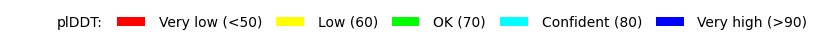

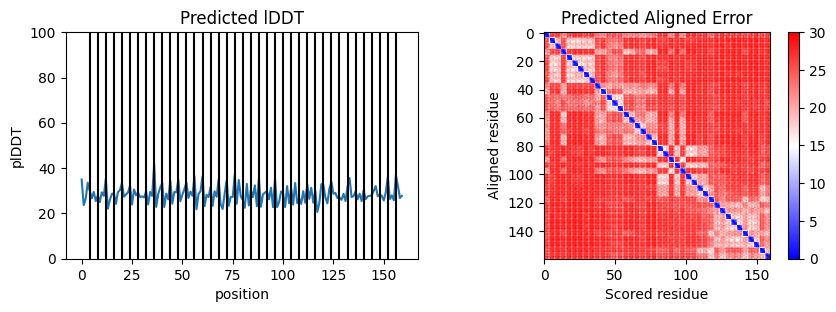

In [9]:
#@title Display 3D structure {run: "auto"}
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

key = model_rank[rank_num-1]
prefix = f"rank_{rank_num}_{key}" 
pred_output_path = os.path.join(output_dir,f'{prefix}_relaxed.pdb')  
if not os.path.isfile(pred_output_path):
  pred_output_path = os.path.join(output_dir,f'{prefix}_unrelaxed.pdb') 

cf.show_pdb(pred_output_path, show_sidechains, show_mainchains, color, chains=len(Ls)).show()
if color == "lDDT": cf.plot_plddt_legend().show()  
if use_ptm:
  cf.plot_confidence(outs[key]["plddt"], outs[key]["pae"], Ls=Ls).show()
else:
  cf.plot_confidence(outs[key]["plddt"], Ls=Ls).show()

In [ ]:
#@title Extra plots
dpi =  100#@param {type:"integer"}
if use_ptm:
  print("predicted alignment error")
  cf.plot_paes([outs[k]["pae"] for k in model_rank],dpi=dpi)
  plt.savefig(os.path.join(output_dir,f'predicted_alignment_error.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
  plt.show()

print("predicted contacts")
cf.plot_adjs([outs[k]["adj"] for k in model_rank],dpi=dpi)
plt.savefig(os.path.join(output_dir,f'predicted_contacts.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted distogram")
cf.plot_dists([outs[k]["dists"] for k in model_rank],dpi=dpi)
plt.savefig(os.path.join(output_dir,f'predicted_distogram.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted LDDT")
cf.plot_plddts([outs[k]["plddt"] for k in model_rank], Ls=Ls, dpi=dpi)
plt.savefig(os.path.join(output_dir,f'predicted_LDDT.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

In [ ]:
#@title Download prediction

#@markdown Once this cell has been executed, a zip-archive with 
#@markdown the obtained prediction will be automatically downloaded 
#@markdown to your computer.

# add settings file
settings_path = os.path.join(output_dir,"settings.txt")
with open(settings_path, "w") as text_file:
  text_file.write(f"notebook=https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/AlphaFold2_advanced.ipynb\n")
  text_file.write(f"sequence={ori_sequence}\n")
  text_file.write(f"msa_method={msa_method}\n")
  text_file.write(f"homooligomer={homooligomer}\n")
  text_file.write(f"pair_msa={pair_msa}\n")
  text_file.write(f"max_msa={max_msa}\n")
  text_file.write(f"cov={cov}\n")
  text_file.write(f"use_amber_relax={use_amber_relax}\n")
  text_file.write(f"use_turbo={use_turbo}\n")
  text_file.write(f"use_ptm={use_ptm}\n")
  text_file.write(f"rank_by={rank_by}\n")
  text_file.write(f"num_models={num_models}\n")
  text_file.write(f"num_samples={num_samples}\n")
  text_file.write(f"num_ensemble={num_ensemble}\n")
  text_file.write(f"max_recycles={max_recycles}\n")
  text_file.write(f"tol={tol}\n")
  text_file.write(f"is_training={is_training}\n")
  text_file.write(f"use_templates=False\n")
  text_file.write(f"-------------------------------------------------\n")

  for n,key in enumerate(model_rank):
    line = f"rank_{n+1}_{key} pLDDT:{outs[key]['pLDDT']:.2f}" + f" pTMscore:{outs[key]['pTMscore']:.4f}" if use_ptm else ""
    text_file.write(line+"\n")

# --- Download the predictions ---
!zip -FSr {output_dir}.zip {output_dir}
files.download(f'{output_dir}.zip')